# DQN Training Experiments for Bowling Atari Environment

**Group Member Name:** Benitha Uwituze Rutagengwa

This notebook loads the Bowling environment and runs **10 training experiments** with different hyperparameter configurations from the CSV file. Each experiment tests 10 different combinations of:
- Learning Rate (lr)
- Gamma (γ) - Discount factor
- Batch Size
- Epsilon parameters (start, end, decay)

For the results of the experiments, including resulting models and logs, please check this [link](https://drive.google.com/drive/folders/1IjhmOzE5Gffvw-5NRbzx4_xjry16RIAq?usp=sharing).

## 1. Setup and Imports


In [ ]:
import gymnasium as gym
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
import pandas as pd
import numpy as np
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

import ale_py


## 2. Load Environment


In [ ]:
def make_env(env_id="ALE/Bowling-v5", render_mode=None):
    """Create and wrap the environment"""
    env = gym.make(env_id, render_mode=render_mode)
    env = Monitor(env)
    return env

print("Loading Bowling environment...")
test_env = make_env()
print(f"Environment loaded: {test_env}")
print(f"Action space: {test_env.action_space}")
print(f"Observation space: {test_env.observation_space}")

obs, info = test_env.reset()
print(f"\nObservation shape: {obs.shape}")
print("Environment is ready!")
test_env.close()

Loading Bowling environment...
Environment loaded: <Monitor<OrderEnforcing<PassiveEnvChecker<AtariEnv<ALE/Bowling-v5>>>>>
Action space: Discrete(6)
Observation space: Box(0, 255, (210, 160, 3), uint8)

Observation shape: (210, 160, 3)
Environment is ready!


## 3. Load Hyperparameters from CSV


In [ ]:
csv_file = "Benitha parameters for experiments.csv"

df = pd.read_csv(csv_file, skiprows=1, skipinitialspace=True)

df.columns = df.columns.str.strip()

df = df.dropna(how='all')

print("Loaded hyperparameter configurations:")
print("="*80)
display(df)

experiments = []
for idx, row in df.iterrows():
    try:
        exp_num = None
        if '#' in row.index:
            exp_num = row['#']
        elif 0 in row.index:
            exp_num = row.iloc[0]
        
        if pd.isna(exp_num) or exp_num == '':
            continue
        
        exp_num = int(float(exp_num))
        
        lr = None
        if 'lr (Learning Rate)' in row.index:
            lr = row['lr (Learning Rate)']
        elif 'lr' in row.index:
            lr = row['lr']
        
        if pd.isna(lr) or lr == '':
            continue
        
        # Build experiment dictionary
        exp = {
            'num': exp_num,
            'lr': float(row['lr (Learning Rate)']),
            'gamma': float(row['gamma (Discount Factor)']),
            'batch_size': int(row['batch_size']),
            'epsilon_start': float(row['epsilon_start']),
            'epsilon_end': float(row['epsilon_end']),
            'epsilon_decay': float(row['epsilon_decay'])
        }
        experiments.append(exp)
    except (ValueError, TypeError, KeyError) as e:
        print(f"  Skipping row {idx}: {e}")
        continue

print(f"\nPrepared {len(experiments)} experiments for training")
if len(experiments) > 0:
    print("\nExperiment configurations:")
    for exp in experiments:
        print(f"  Exp {exp['num']}: lr={exp['lr']}, gamma={exp['gamma']}, batch={exp['batch_size']}, "
              f"eps={exp['epsilon_start']}->{exp['epsilon_end']}, decay={exp['epsilon_decay']}")
else:
    print("\nWARNING: No experiments loaded! Check CSV file format.")
    print("Expected columns: #, lr (Learning Rate), gamma (Discount Factor), batch_size, epsilon_start, epsilon_end, epsilon_decay")

Loaded hyperparameter configurations:


,1,0.001,0.99,32,1.1,0.05,1.00E-05
0,2,0.0005,0.95,64,1,0.10,0.00005
1,3,0.0020,0.97,32,1,0.05,0.00002
2,4,0.0008,0.90,128,1,0.05,0.00010
3,5,0.0015,0.99,64,1,0.10,0.00010
4,6,0.0003,0.95,128,1,0.05,0.00050
5,7,0.0040,0.92,32,1,0.10,0.00002
6,8,0.0012,0.96,64,1,0.05,0.00003
7,9,0.0007,0.93,64,1,0.10,0.00001
8,10,0.0030,0.99,32,1,0.05,0.00004



Prepared 0 experiments for training

Expected columns: #, lr (Learning Rate), gamma (Discount Factor), batch_size, epsilon_start, epsilon_end, epsilon_decay


## 4. Training Function


In [ ]:
def convert_epsilon_decay(epsilon_decay):
    """Convert epsilon_decay rate to exploration_fraction"""
    if epsilon_decay < 0.0001:
        return 0.8  
    elif epsilon_decay < 0.0005:
        return 0.5
    else:
        return 0.2 

def train_experiment(exp_config, total_timesteps=50000, policy_type="CnnPolicy"):
    
    exp_num = exp_config['num']
    
    print(f"EXPERIMENT {exp_num}")
    print(f"Policy: {policy_type}")
    print(f"Learning Rate: {exp_config['lr']}")
    print(f"Gamma: {exp_config['gamma']}")
    print(f"Batch Size: {exp_config['batch_size']}")
    print(f"Epsilon: {exp_config['epsilon_start']} -> {exp_config['epsilon_end']}")
    
    # Convert epsilon_decay to exploration_fraction
    exploration_fraction = convert_epsilon_decay(exp_config['epsilon_decay'])
    print(f"Epsilon Decay Rate: {exp_config['epsilon_decay']} -> Exploration Fraction: {exploration_fraction}")
    print(f"Total Timesteps: {total_timesteps}")
    
    # Create directories
    experiment_name = f"benitha_exp_{exp_num}"
    log_dir = f"benitha_logs/{experiment_name}_{policy_type}"
    model_dir = f"benitha_models/{experiment_name}_{policy_type}"
    os.makedirs(log_dir, exist_ok=True)
    os.makedirs(model_dir, exist_ok=True)
    
    # Create environments
    env = DummyVecEnv([lambda: make_env()])
    eval_env = DummyVecEnv([lambda: make_env()])
    
    # Initialize DQN agent
    model = DQN(
        policy_type,
        env,
        learning_rate=exp_config['lr'],
        gamma=exp_config['gamma'],
        batch_size=exp_config['batch_size'],
        buffer_size=5000,
        exploration_initial_eps=exp_config['epsilon_start'],
        exploration_final_eps=exp_config['epsilon_end'],
        exploration_fraction=exploration_fraction,
        verbose=1,
        tensorboard_log=log_dir,
        device="auto"
    )
    
    eval_callback = EvalCallback(
        eval_env,
        best_model_save_path=model_dir,
        log_path=log_dir,
        eval_freq=5000,
        deterministic=True,
        render=False
    )
    
    checkpoint_callback = CheckpointCallback(
        save_freq=10000,
        save_path=model_dir,
        name_prefix="dqn_checkpoint"
    )
    
    # Train the model
    print("Starting training...")
    model.learn(
        total_timesteps=total_timesteps,
        callback=[eval_callback, checkpoint_callback],
        progress_bar=True
    )
    
    # Save final model
    final_model_path = f"{model_dir}/benitha_dqn_model.zip"
    model.save(final_model_path)
    print(f"\nModel saved to: {final_model_path}")
    
    training_info = {
        'experiment': exp_num,
        'policy': policy_type,
        'final_timesteps': total_timesteps
    }
    
    if hasattr(eval_callback, 'best_mean_reward'):
        training_info['best_mean_reward'] = eval_callback.best_mean_reward
        training_info['n_eval_episodes'] = eval_callback.n_eval_episodes
    
    return model, log_dir, model_dir, training_info

## 6. Run Individual Experiments



In [ ]:
TOTAL_TIMESTEPS = 30000
POLICY_TYPE = "CnnPolicy" 

if os.path.exists('benitha_experiment_results.csv'):
    try:
        existing_df = pd.read_csv('benitha_experiment_results.csv')
        all_results = existing_df.to_dict('records')
        print(f"Loaded {len(all_results)} existing experiment results from CSV")
        successful = [r for r in all_results if r.get('status') == 'success']
        print(f"  - {len(successful)} successful experiments")
        print(f"  - {len(all_results) - len(successful)} failed/incomplete experiments")
    except Exception as e:
        print(f"Could not load existing results: {e}")
        all_results = []
        all_training_info = []
else:
    all_results = []
    all_training_info = []

print(f"\nConfiguration:")
print(f"  Total timesteps per experiment: {TOTAL_TIMESTEPS}")
print(f"  Policy type: {POLICY_TYPE}")
print(f"  Total experiments to run: 10")
print(f"  Estimated total time: ~{10 * TOTAL_TIMESTEPS / 1000:.0f} minutes")
print(f"\nNote: Completed experiments will be skipped automatically.")


Loaded 7 existing experiment results from CSV
  - 7 successful experiments
  - 0 failed/incomplete experiments

Configuration:
  Total timesteps per experiment: 30000
  Policy type: CnnPolicy
  Total experiments to run: 10
  Estimated total time: ~300 minutes

Note: Completed experiments will be skipped automatically.


## Experiment 1


In [ ]:
# Check if already completed
exp_1_completed = any(r.get('experiment') == 1 and r.get('status') == 'success' for r in all_results)

if exp_1_completed:
    print("Experiment 1 already completed. Skipping.")
else:
    try:
        start_time = datetime.now()
        
        exp_config = {
            'num': 1,
            'lr': 0.0010,
            'gamma': 0.99,
            'batch_size': 32,
            'epsilon_start': 1.0,
            'epsilon_end': 0.05,
            'epsilon_decay': 1e-05
        }
        
        model, log_dir, model_dir, training_info = train_experiment(
            exp_config,
            total_timesteps=TOTAL_TIMESTEPS,
            policy_type=POLICY_TYPE
        )
        
        end_time = datetime.now()
        duration = (end_time - start_time).total_seconds() / 60
        
        result = {
            'experiment': 1,
            'status': 'success',
            'duration_minutes': duration,
            'log_dir': log_dir,
            'model_dir': model_dir,
            'best_mean_reward': training_info.get('best_mean_reward', None),
            **exp_config
        }
        
        all_results.append(result)

        results_df = pd.DataFrame(all_results)
        results_df.to_csv('benitha_experiment_results.csv', index=False)
        

        print(f"Experiment 1 completed in {duration:.2f} minutes")
        if training_info.get('best_mean_reward') is not None:
            print(f"  Best Mean Reward: {training_info['best_mean_reward']:.2f}")
        print(f"  Model saved to: {model_dir}/benitha_dqn_model.zip")
        print(f"  Results saved to: benitha_experiment_results.csv")
        
    except Exception as e:
        print(f"\nError in experiment 1: {e}")
        import traceback
        traceback.print_exc()
        result = {
            'experiment': 1,
            'status': 'failed',
            'error': str(e),
            **exp_config
        }
        all_results.append(result)

Experiment 1 already completed. Skipping.


## Experiment 2


In [ ]:
# Check if already completed
exp_2_completed = any(r.get('experiment') == 2 and r.get('status') == 'success' for r in all_results)

if exp_2_completed:
    print("Experiment 2 already completed. Skipping.")
else:
    try:
        start_time = datetime.now()
        
        exp_config = {
            'num': 2,
            'lr': 0.0005,
            'gamma': 0.95,
            'batch_size': 64,
            'epsilon_start': 1.0,
            'epsilon_end': 0.1,
            'epsilon_decay': 5e-05
        }
        
        model, log_dir, model_dir, training_info = train_experiment(
            exp_config,
            total_timesteps=TOTAL_TIMESTEPS,
            policy_type=POLICY_TYPE
        )
        
        end_time = datetime.now()
        duration = (end_time - start_time).total_seconds() / 60 
        
        result = {
            'experiment': 2,
            'status': 'success',
            'duration_minutes': duration,
            'log_dir': log_dir,
            'model_dir': model_dir,
            'best_mean_reward': training_info.get('best_mean_reward', None),
            **exp_config
        }
        
        all_results.append(result)

        # Save results to CSV after each experiment
        results_df = pd.DataFrame(all_results)
        results_df.to_csv('benitha_experiment_results.csv', index=False)
        
        print(f"Experiment 2 completed in {duration:.2f} minutes")
        print(f"  Model saved to: {model_dir}/benitha_dqn_model.zip")
        print(f"  Results saved to: benitha_experiment_results.csv")
        if training_info.get('best_mean_reward') is not None:
            print(f"  Best Mean Reward: {training_info['best_mean_reward']:.2f}")
        
    except Exception as e:
        print(f"\nError in experiment 2: {e}")
        import traceback
        traceback.print_exc()
        result = {
            'experiment': 2,
            'status': 'failed',
            'error': str(e),
            **exp_config
        }
        all_results.append(result)

Experiment 2 already completed. Skipping.


## Experiment 3


In [ ]:
# Check if already completed
exp_3_completed = any(r.get('experiment') == 3 and r.get('status') == 'success' for r in all_results)

if exp_3_completed:
    print("Experiment 3 already completed. Skipping.")
else:
    try:
        start_time = datetime.now()
        
        exp_config = {
            'num': 3,
            'lr': 0.0020,
            'gamma': 0.97,
            'batch_size': 32,
            'epsilon_start': 1.0,
            'epsilon_end': 0.05,
            'epsilon_decay': 2e-05
        }
        
        model, log_dir, model_dir, training_info = train_experiment(
            exp_config,
            total_timesteps=TOTAL_TIMESTEPS,
            policy_type=POLICY_TYPE
        )
        
        end_time = datetime.now()
        duration = (end_time - start_time).total_seconds() / 60 
        
        result = {
            'experiment': 3,
            'status': 'success',
            'duration_minutes': duration,
            'log_dir': log_dir,
            'model_dir': model_dir,
            'best_mean_reward': training_info.get('best_mean_reward', None),
            **exp_config
        }
        
        all_results.append(result)

        # Save results to CSV after each experiment
        results_df = pd.DataFrame(all_results)
        results_df.to_csv('benitha_experiment_results.csv', index=False)
        
        print(f"Experiment 3 completed in {duration:.2f} minutes")
        print(f"  Model saved to: {model_dir}/benitha_dqn_model.zip")
        print(f"  Results saved to: benitha_experiment_results.csv")
        if training_info.get('best_mean_reward') is not None:
            print(f"  Best Mean Reward: {training_info['best_mean_reward']:.2f}")
        
    except Exception as e:
        print(f"\nError in experiment 3: {e}")
        import traceback
        traceback.print_exc()
        result = {
            'experiment': 3,
            'status': 'failed',
            'error': str(e),
            **exp_config
        }
        all_results.append(result)

Experiment 3 already completed. Skipping.


## Experiment 4


In [ ]:

# Check if already completed
exp_4_completed = any(r.get('experiment') == 4 and r.get('status') == 'success' for r in all_results)

if exp_4_completed:
    print("Experiment 4 already completed. Skipping.")
else:
    try:
        start_time = datetime.now()
        
        exp_config = {
            'num': 4,
            'lr': 0.0008,
            'gamma': 0.90,
            'batch_size': 128,
            'epsilon_start': 1.0,
            'epsilon_end': 0.05,
            'epsilon_decay': 1e-04
        }
        
        model, log_dir, model_dir, training_info = train_experiment(
            exp_config,
            total_timesteps=TOTAL_TIMESTEPS,
            policy_type=POLICY_TYPE
        )
        
        end_time = datetime.now()
        duration = (end_time - start_time).total_seconds() / 60 
        
        result = {
            'experiment': 4,
            'status': 'success',
            'duration_minutes': duration,
            'log_dir': log_dir,
            'model_dir': model_dir,
            'best_mean_reward': training_info.get('best_mean_reward', None),
            **exp_config
        }
        
        all_results.append(result)

        results_df = pd.DataFrame(all_results)
        results_df.to_csv('benitha_experiment_results.csv', index=False)
        
        print(f"Experiment 4 completed in {duration:.2f} minutes")
        print(f"  Model saved to: {model_dir}/benitha_dqn_model.zip")
        print(f"  Results saved to: benitha_experiment_results.csv")
        if training_info.get('best_mean_reward') is not None:
            print(f"  Best Mean Reward: {training_info['best_mean_reward']:.2f}")
        
    except Exception as e:
        print(f"\nError in experiment 4: {e}")
        import traceback
        traceback.print_exc()
        result = {
            'experiment': 4,
            'status': 'failed',
            'error': str(e),
            **exp_config
        }
        all_results.append(result)

Experiment 4 already completed. Skipping.


## Experiment 5


In [ ]:
# Check if already completed
exp_5_completed = any(r.get('experiment') == 5 and r.get('status') == 'success' for r in all_results)

if exp_5_completed:
    print("Experiment 5 already completed. Skipping.")
else:
    try:
        start_time = datetime.now()
        
        exp_config = {
            'num': 5,
            'lr': 0.0015,
            'gamma': 0.99,
            'batch_size': 64,
            'epsilon_start': 1.0,
            'epsilon_end': 0.1,
            'epsilon_decay': 1e-04
        }
        
        model, log_dir, model_dir, training_info = train_experiment(
            exp_config,
            total_timesteps=TOTAL_TIMESTEPS,
            policy_type=POLICY_TYPE
        )
        
        end_time = datetime.now()
        duration = (end_time - start_time).total_seconds() / 60 
        
        result = {
            'experiment': 5,
            'status': 'success',
            'duration_minutes': duration,
            'log_dir': log_dir,
            'model_dir': model_dir,
            'best_mean_reward': training_info.get('best_mean_reward', None),
            **exp_config
        }
        
        all_results.append(result)

        results_df = pd.DataFrame(all_results)
        results_df.to_csv('benitha_experiment_results.csv', index=False)
        
        print(f"Experiment 5 completed in {duration:.2f} minutes")
        print(f"  Model saved to: {model_dir}/benitha_dqn_model.zip")
        print(f"  Results saved to: benitha_experiment_results.csv")
        if training_info.get('best_mean_reward') is not None:
            print(f"  Best Mean Reward: {training_info['best_mean_reward']:.2f}")
        
    except Exception as e:
        print(f"\nError in experiment 5: {e}")
        import traceback
        traceback.print_exc()
        result = {
            'experiment': 5,
            'status': 'failed',
            'error': str(e),
            **exp_config
        }
        all_results.append(result)

Experiment 5 already completed. Skipping.


## Experiment 6


In [ ]:
# Check if already completed
exp_6_completed = any(r.get('experiment') == 6 and r.get('status') == 'success' for r in all_results)

if exp_6_completed:
    print("Experiment 6 already completed. Skipping.")
else:
    try:
        start_time = datetime.now()
        
        exp_config = {
            'num': 6,
            'lr': 0.0003,
            'gamma': 0.95,
            'batch_size': 128,
            'epsilon_start': 1.0,
            'epsilon_end': 0.05,
            'epsilon_decay': 5e-04
        }
        
        model, log_dir, model_dir, training_info = train_experiment(
            exp_config,
            total_timesteps=TOTAL_TIMESTEPS,
            policy_type=POLICY_TYPE
        )
        
        end_time = datetime.now()
        duration = (end_time - start_time).total_seconds() / 60 
        
        result = {
            'experiment': 6,
            'status': 'success',
            'duration_minutes': duration,
            'log_dir': log_dir,
            'model_dir': model_dir,
            'best_mean_reward': training_info.get('best_mean_reward', None),
            **exp_config
        }
        
        all_results.append(result)

        results_df = pd.DataFrame(all_results)
        results_df.to_csv('benitha_experiment_results.csv', index=False)
        
        print(f"Experiment 6 completed in {duration:.2f} minutes")
        print(f"  Model saved to: {model_dir}/benitha_dqn_model.zip")
        print(f"  Results saved to: benitha_experiment_results.csv")
        if training_info.get('best_mean_reward') is not None:
            print(f"  Best Mean Reward: {training_info['best_mean_reward']:.2f}")
        
    except Exception as e:
        print(f"\nError in experiment 6: {e}")
        import traceback
        traceback.print_exc()
        result = {
            'experiment': 6,
            'status': 'failed',
            'error': str(e),
            **exp_config
        }
        all_results.append(result)

Experiment 6 already completed. Skipping.


## Experiment 7


In [ ]:
# Check if already completed
exp_7_completed = any(r.get('experiment') == 7 and r.get('status') == 'success' for r in all_results)

if exp_7_completed:
    print("Experiment 7 already completed. Skipping.")
else:
    try:
        start_time = datetime.now()
        
        exp_config = {
            'num': 7,
            'lr': 0.0040,
            'gamma': 0.92,
            'batch_size': 32,
            'epsilon_start': 1.0,
            'epsilon_end': 0.1,
            'epsilon_decay': 2e-05
        }
        
        model, log_dir, model_dir, training_info = train_experiment(
            exp_config,
            total_timesteps=TOTAL_TIMESTEPS,
            policy_type=POLICY_TYPE
        )
        
        end_time = datetime.now()
        duration = (end_time - start_time).total_seconds() / 60 
        
        result = {
            'experiment': 7,
            'status': 'success',
            'duration_minutes': duration,
            'log_dir': log_dir,
            'model_dir': model_dir,
            'best_mean_reward': training_info.get('best_mean_reward', None),
            **exp_config
        }
        
        all_results.append(result)

        results_df = pd.DataFrame(all_results)
        results_df.to_csv('benitha_experiment_results.csv', index=False)
        
        print(f"Experiment 7 completed in {duration:.2f} minutes")
        print(f"  Model saved to: {model_dir}/benitha_dqn_model.zip")
        print(f"  Results saved to: benitha_experiment_results.csv")
        if training_info.get('best_mean_reward') is not None:
            print(f"  Best Mean Reward: {training_info['best_mean_reward']:.2f}")
        
    except Exception as e:
        print(f"\nError in experiment 7: {e}")
        import traceback
        traceback.print_exc()
        result = {
            'experiment': 7,
            'status': 'failed',
            'error': str(e),
            **exp_config
        }
        all_results.append(result)

Experiment 7 already completed. Skipping.


## Experiment 8


In [ ]:
exp_8_completed = any(r.get('experiment') == 8 and r.get('status') == 'success' for r in all_results)

if exp_8_completed:
    print("Experiment 8 already completed. Skipping.")
else:
    try:
        start_time = datetime.now()
        
        exp_config = {
            'num': 8,
            'lr': 0.0012,
            'gamma': 0.96,
            'batch_size': 64,
            'epsilon_start': 1.0,
            'epsilon_end': 0.05,
            'epsilon_decay': 3e-05
        }
        
        model, log_dir, model_dir, training_info = train_experiment(
            exp_config,
            total_timesteps=TOTAL_TIMESTEPS,
            policy_type=POLICY_TYPE
        )
        
        end_time = datetime.now()
        duration = (end_time - start_time).total_seconds() / 60
        
        result = {
            'experiment': 8,
            'status': 'success',
            'duration_minutes': duration,
            'log_dir': log_dir,
            'model_dir': model_dir,
            'best_mean_reward': training_info.get('best_mean_reward', None),
            **exp_config
        }
        
        all_results.append(result)

        results_df = pd.DataFrame(all_results)
        results_df.to_csv('benitha_experiment_results.csv', index=False)
        
        print(f"Experiment 8 completed in {duration:.2f} minutes")
        print(f"  Model saved to: {model_dir}/benitha_dqn_model.zip")
        print(f"  Results saved to: benitha_experiment_results.csv")
        if training_info.get('best_mean_reward') is not None:
            print(f"  Best Mean Reward: {training_info['best_mean_reward']:.2f}")
        
    except Exception as e:
        print(f"\nError in experiment 8: {e}")
        import traceback
        traceback.print_exc()
        result = {
            'experiment': 8,
            'status': 'failed',
            'error': str(e),
            **exp_config
        }
        all_results.append(result)

EXPERIMENT 8
Policy: CnnPolicy
Learning Rate: 0.0012
Gamma: 0.96
Batch Size: 64
Epsilon: 1.0 -> 0.05
Epsilon Decay Rate: 3e-05 -> Exploration Fraction: 0.8
Total Timesteps: 30000
Using cpu device
Wrapping the env in a VecTransposeImage.
Starting training...
Logging to benitha_logs/benitha_exp_8_CnnPolicy\DQN_2


Eval num_timesteps=5000, episode_reward=0.00 +/- 0.00

Episode length: 2002.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 2e+03    |
|    mean_reward      | 0        |
| rollout/            |          |
|    exploration_rate | 0.802    |
| time/               |          |
|    total_timesteps  | 5000     |
| train/              |          |
|    learning_rate    | 0.0012   |
|    loss             | 3.66e-05 |
|    n_updates        | 1224     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.11e+03 |
|    ep_rew_mean      | 21.8     |
|    exploration_rate | 0.666    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 6        |
|    time_elapsed     | 1389     |
|    total_timesteps  | 8435     |
| train/              |          |
|    learning_rate    | 0.0012   |
|    loss             | 5.93e-06 |
|    n_updates        | 2083     |
----------------------------------


Eval num_timesteps=10000, episode_reward=0.00 +/- 0.00

Episode length: 27000.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 2.7e+04  |
|    mean_reward      | 0        |
| rollout/            |          |
|    exploration_rate | 0.604    |
| time/               |          |
|    total_timesteps  | 10000    |
| train/              |          |
|    learning_rate    | 0.0012   |
|    loss             | 8.36e-06 |
|    n_updates        | 2474     |
----------------------------------


Eval num_timesteps=15000, episode_reward=30.00 +/- 0.00

Episode length: 2161.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 2.16e+03 |
|    mean_reward      | 30       |
| rollout/            |          |
|    exploration_rate | 0.406    |
| time/               |          |
|    total_timesteps  | 15000    |
| train/              |          |
|    learning_rate    | 0.0012   |
|    loss             | 3.85e-06 |
|    n_updates        | 3724     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.11e+03 |
|    ep_rew_mean      | 24       |
|    exploration_rate | 0.331    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 5        |
|    time_elapsed     | 3363     |
|    total_timesteps  | 16912    |
| train/              |          |
|    learning_rate    | 0.0012   |
|    loss             | 3.84e-06 |
|    n_updates        | 4202     |
----------------------------------


Eval num_timesteps=20000, episode_reward=0.00 +/- 0.00

Episode length: 27000.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 2.7e+04  |
|    mean_reward      | 0        |
| rollout/            |          |
|    exploration_rate | 0.208    |
| time/               |          |
|    total_timesteps  | 20000    |
| train/              |          |
|    learning_rate    | 0.0012   |
|    loss             | 9.07e-06 |
|    n_updates        | 4974     |
----------------------------------


Eval num_timesteps=25000, episode_reward=0.00 +/- 0.00

Episode length: 27000.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 2.7e+04  |
|    mean_reward      | 0        |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 25000    |
| train/              |          |
|    learning_rate    | 0.0012   |
|    loss             | 1.05e-05 |
|    n_updates        | 6224     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.15e+03 |
|    ep_rew_mean      | 26.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 4        |
|    time_elapsed     | 5651     |
|    total_timesteps  | 25778    |
| train/              |          |
|    learning_rate    | 0.0012   |
|    loss             | 0.00718  |
|    n_updates        | 6419     |
----------------------------------


Eval num_timesteps=30000, episode_reward=0.00 +/- 0.00

Episode length: 27000.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 2.7e+04  |
|    mean_reward      | 0        |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 30000    |
| train/              |          |
|    learning_rate    | 0.0012   |
|    loss             | 8.31e-07 |
|    n_updates        | 7474     |
----------------------------------



Model saved to: benitha_models/benitha_exp_8_CnnPolicy/benitha_dqn_model.zip
Experiment 8 completed in 112.72 minutes
  Model saved to: benitha_models/benitha_exp_8_CnnPolicy/benitha_dqn_model.zip
  Results saved to: benitha_experiment_results.csv
  Best Mean Reward: 30.00


## Experiment 9


In [ ]:
# Check if already completed
exp_9_completed = any(r.get('experiment') == 9 and r.get('status') == 'success' for r in all_results)

if exp_9_completed:
    print("Experiment 9 already completed. Skipping.")
else:
    try:
        start_time = datetime.now()
        
        exp_config = {
            'num': 9,
            'lr': 0.0007,
            'gamma': 0.93,
            'batch_size': 64,
            'epsilon_start': 1.0,
            'epsilon_end': 0.1,
            'epsilon_decay': 1e-05
        }
        
        model, log_dir, model_dir, training_info = train_experiment(
            exp_config,
            total_timesteps=TOTAL_TIMESTEPS,
            policy_type=POLICY_TYPE
        )
        
        end_time = datetime.now()
        duration = (end_time - start_time).total_seconds() / 60 
        
        result = {
            'experiment': 9,
            'status': 'success',
            'duration_minutes': duration,
            'log_dir': log_dir,
            'model_dir': model_dir,
            'best_mean_reward': training_info.get('best_mean_reward', None),
            **exp_config
        }
        
        all_results.append(result)

        # Save results to CSV after each experiment
        results_df = pd.DataFrame(all_results)
        results_df.to_csv('benitha_experiment_results.csv', index=False)
        
        print(f"Experiment 9 completed in {duration:.2f} minutes")
        print(f"  Model saved to: {model_dir}/benitha_dqn_model.zip")
        print(f"  Results saved to: benitha_experiment_results.csv")
        if training_info.get('best_mean_reward') is not None:
            print(f"  Best Mean Reward: {training_info['best_mean_reward']:.2f}")
        
    except Exception as e:
        print(f"\nError in experiment 9: {e}")
        import traceback
        traceback.print_exc()
        result = {
            'experiment': 9,
            'status': 'failed',
            'error': str(e),
            **exp_config
        }
        all_results.append(result)

EXPERIMENT 9
Policy: CnnPolicy
Learning Rate: 0.0007
Gamma: 0.93
Batch Size: 64
Epsilon: 1.0 -> 0.1
Epsilon Decay Rate: 1e-05 -> Exploration Fraction: 0.8
Total Timesteps: 30000
Using cpu device
Wrapping the env in a VecTransposeImage.
Starting training...
Logging to benitha_logs/benitha_exp_9_CnnPolicy\DQN_1


Eval num_timesteps=5000, episode_reward=0.00 +/- 0.00

Episode length: 27000.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 2.7e+04  |
|    mean_reward      | 0        |
| rollout/            |          |
|    exploration_rate | 0.813    |
| time/               |          |
|    total_timesteps  | 5000     |
| train/              |          |
|    learning_rate    | 0.0007   |
|    loss             | 9.6e-06  |
|    n_updates        | 1224     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.1e+03  |
|    ep_rew_mean      | 25.2     |
|    exploration_rate | 0.685    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 6        |
|    time_elapsed     | 1339     |
|    total_timesteps  | 8408     |
| train/              |          |
|    learning_rate    | 0.0007   |
|    loss             | 1.2e-05  |
|    n_updates        | 2076     |
----------------------------------


Eval num_timesteps=10000, episode_reward=30.00 +/- 0.00

Episode length: 2161.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 2.16e+03 |
|    mean_reward      | 30       |
| rollout/            |          |
|    exploration_rate | 0.625    |
| time/               |          |
|    total_timesteps  | 10000    |
| train/              |          |
|    learning_rate    | 0.0007   |
|    loss             | 2.05e-05 |
|    n_updates        | 2474     |
----------------------------------


New best mean reward!

Eval num_timesteps=15000, episode_reward=30.00 +/- 0.00

Episode length: 2161.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 2.16e+03 |
|    mean_reward      | 30       |
| rollout/            |          |
|    exploration_rate | 0.438    |
| time/               |          |
|    total_timesteps  | 15000    |
| train/              |          |
|    learning_rate    | 0.0007   |
|    loss             | 9.8e-06  |
|    n_updates        | 3724     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.11e+03 |
|    ep_rew_mean      | 22.5     |
|    exploration_rate | 0.366    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 8        |
|    time_elapsed     | 2084     |
|    total_timesteps  | 16904    |
| train/              |          |
|    learning_rate    | 0.0007   |
|    loss             | 1.63e-05 |
|    n_updates        | 4200     |
----------------------------------


Eval num_timesteps=20000, episode_reward=0.00 +/- 0.00

Episode length: 2002.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 2e+03    |
|    mean_reward      | 0        |
| rollout/            |          |
|    exploration_rate | 0.25     |
| time/               |          |
|    total_timesteps  | 20000    |
| train/              |          |
|    learning_rate    | 0.0007   |
|    loss             | 9.89e-06 |
|    n_updates        | 4974     |
----------------------------------


Eval num_timesteps=25000, episode_reward=0.00 +/- 0.00

Episode length: 27000.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 2.7e+04  |
|    mean_reward      | 0        |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 25000    |
| train/              |          |
|    learning_rate    | 0.0007   |
|    loss             | 5.42e-06 |
|    n_updates        | 6224     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.13e+03 |
|    ep_rew_mean      | 23       |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 12       |
|    fps              | 7        |
|    time_elapsed     | 3584     |
|    total_timesteps  | 25599    |
| train/              |          |
|    learning_rate    | 0.0007   |
|    loss             | 1.69e-05 |
|    n_updates        | 6374     |
----------------------------------


Eval num_timesteps=30000, episode_reward=0.00 +/- 0.00

Episode length: 27000.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 2.7e+04  |
|    mean_reward      | 0        |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 30000    |
| train/              |          |
|    learning_rate    | 0.0007   |
|    loss             | 0.00734  |
|    n_updates        | 7474     |
----------------------------------



Model saved to: benitha_models/benitha_exp_9_CnnPolicy/benitha_dqn_model.zip
Experiment 9 completed in 78.38 minutes
  Model saved to: benitha_models/benitha_exp_9_CnnPolicy/benitha_dqn_model.zip
  Results saved to: benitha_experiment_results.csv
  Best Mean Reward: 30.00


## Experiment 10


In [ ]:
# Check if already completed
exp_10_completed = any(r.get('experiment') == 10 and r.get('status') == 'success' for r in all_results)

if exp_10_completed:
    print("Experiment 10 already completed. Skipping.")
else:
    try:
        start_time = datetime.now()
        
        exp_config = {
            'num': 10,
            'lr': 0.0030,
            'gamma': 0.99,
            'batch_size': 32,
            'epsilon_start': 1.0,
            'epsilon_end': 0.05,
            'epsilon_decay': 4e-05
        }
        
        model, log_dir, model_dir, training_info = train_experiment(
            exp_config,
            total_timesteps=TOTAL_TIMESTEPS,
            policy_type=POLICY_TYPE
        )
        
        end_time = datetime.now()
        duration = (end_time - start_time).total_seconds() / 60  # in minutes
        
        result = {
            'experiment': 10,
            'status': 'success',
            'duration_minutes': duration,
            'log_dir': log_dir,
            'model_dir': model_dir,
            'best_mean_reward': training_info.get('best_mean_reward', None),
            **exp_config
        }
        
        all_results.append(result)

        results_df = pd.DataFrame(all_results)
        results_df.to_csv('benitha_experiment_results.csv', index=False)
        
        print(f"Experiment 10 completed in {duration:.2f} minutes")
        print(f"  Model saved to: {model_dir}/benitha_dqn_model.zip")
        print(f"  Results saved to: benitha_experiment_results.csv")
        if training_info.get('best_mean_reward') is not None:
            print(f"  Best Mean Reward: {training_info['best_mean_reward']:.2f}")
        
    except Exception as e:
        print(f"\nError in experiment 10: {e}")
        import traceback
        traceback.print_exc()
        result = {
            'experiment': 10,
            'status': 'failed',
            'error': str(e),
            **exp_config
        }
        all_results.append(result)

EXPERIMENT 10
Policy: CnnPolicy
Learning Rate: 0.003
Gamma: 0.99
Batch Size: 32
Epsilon: 1.0 -> 0.05
Epsilon Decay Rate: 4e-05 -> Exploration Fraction: 0.8
Total Timesteps: 30000
Using cpu device
Wrapping the env in a VecTransposeImage.
Starting training...
Logging to benitha_logs/benitha_exp_10_CnnPolicy\DQN_1


Eval num_timesteps=5000, episode_reward=0.00 +/- 0.00

Episode length: 27000.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 2.7e+04  |
|    mean_reward      | 0        |
| rollout/            |          |
|    exploration_rate | 0.802    |
| time/               |          |
|    total_timesteps  | 5000     |
| train/              |          |
|    learning_rate    | 0.003    |
|    loss             | 1.16e-05 |
|    n_updates        | 1224     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.11e+03 |
|    ep_rew_mean      | 18       |
|    exploration_rate | 0.666    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 7        |
|    time_elapsed     | 1186     |
|    total_timesteps  | 8429     |
| train/              |          |
|    learning_rate    | 0.003    |
|    loss             | 5.46e-06 |
|    n_updates        | 2082     |
----------------------------------


Eval num_timesteps=10000, episode_reward=30.00 +/- 0.00

Episode length: 2161.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 2.16e+03 |
|    mean_reward      | 30       |
| rollout/            |          |
|    exploration_rate | 0.604    |
| time/               |          |
|    total_timesteps  | 10000    |
| train/              |          |
|    learning_rate    | 0.003    |
|    loss             | 5.03e-05 |
|    n_updates        | 2474     |
----------------------------------


New best mean reward!

Eval num_timesteps=15000, episode_reward=0.00 +/- 0.00

Episode length: 27000.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 2.7e+04  |
|    mean_reward      | 0        |
| rollout/            |          |
|    exploration_rate | 0.406    |
| time/               |          |
|    total_timesteps  | 15000    |
| train/              |          |
|    learning_rate    | 0.003    |
|    loss             | 6.91e-06 |
|    n_updates        | 3724     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.12e+03 |
|    ep_rew_mean      | 22.1     |
|    exploration_rate | 0.328    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 6        |
|    time_elapsed     | 2483     |
|    total_timesteps  | 16974    |
| train/              |          |
|    learning_rate    | 0.003    |
|    loss             | 1.61e-05 |
|    n_updates        | 4218     |
----------------------------------


Eval num_timesteps=20000, episode_reward=0.00 +/- 0.00

Episode length: 27000.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 2.7e+04  |
|    mean_reward      | 0        |
| rollout/            |          |
|    exploration_rate | 0.208    |
| time/               |          |
|    total_timesteps  | 20000    |
| train/              |          |
|    learning_rate    | 0.003    |
|    loss             | 1.84e-05 |
|    n_updates        | 4974     |
----------------------------------


Eval num_timesteps=25000, episode_reward=0.00 +/- 0.00

Episode length: 27000.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 2.7e+04  |
|    mean_reward      | 0        |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 25000    |
| train/              |          |
|    learning_rate    | 0.003    |
|    loss             | 1.33e-05 |
|    n_updates        | 6224     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.14e+03 |
|    ep_rew_mean      | 23.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 5        |
|    time_elapsed     | 4974     |
|    total_timesteps  | 25723    |
| train/              |          |
|    learning_rate    | 0.003    |
|    loss             | 0.0779   |
|    n_updates        | 6405     |
----------------------------------


Eval num_timesteps=30000, episode_reward=0.00 +/- 0.00

Episode length: 2002.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 2e+03    |
|    mean_reward      | 0        |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 30000    |
| train/              |          |
|    learning_rate    | 0.003    |
|    loss             | 0.0761   |
|    n_updates        | 7474     |
----------------------------------



Model saved to: benitha_models/benitha_exp_10_CnnPolicy/benitha_dqn_model.zip
Experiment 10 completed in 93.75 minutes
  Model saved to: benitha_models/benitha_exp_10_CnnPolicy/benitha_dqn_model.zip
  Results saved to: benitha_experiment_results.csv
  Best Mean Reward: 30.00


## 6.5. Experiments Summary


In [ ]:
# Summary of all completed experiments
if os.path.exists('benitha_experiment_results.csv'):
    try:
        results_df = pd.read_csv('benitha_experiment_results.csv')
        all_results = results_df.to_dict('records')
    except:
        all_results = []
elif 'all_results' in globals():
    pass
else:
    all_results = []

if len(all_results) > 0:
    successful = [r for r in all_results if r.get('status') == 'success']
    failed = [r for r in all_results if r.get('status') == 'failed']
    
    print(f"EXPERIMENTS SUMMARY")
    print(f"\nCompleted: {len(successful)}/10")
    print(f"Failed: {len(failed)}/10")
    
    if len(successful) > 0:
        print(f"\nSuccessful experiments: {sorted([r['experiment'] for r in successful])}")
        rewards = [r.get('best_mean_reward') for r in successful if pd.notna(r.get('best_mean_reward'))]
        if rewards:
            print(f"\nReward Statistics:")
            print(f"  Best: {max(rewards):.2f}")
            print(f"  Average: {sum(rewards)/len(rewards):.2f}")
    if len(failed) > 0:
        print(f"\nFailed experiments: {sorted([r['experiment'] for r in failed])}")
    
    # Save results to CSV
    results_df = pd.DataFrame(all_results)
    results_df.to_csv('benitha_experiment_results.csv', index=False)
    print(f"\nResults saved to benitha_experiment_results.csv")
else:
    print("No experiments completed yet. Run the experiment cells above.")

EXPERIMENTS SUMMARY

Completed: 10/10
Failed: 0/10

Successful experiments: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

Reward Statistics:
  Best: 35.40
  Average: 21.34

Results saved to benitha_experiment_results.csv


## 7. Compare MLPPolicy vs CNNPolicy


In [ ]:
# Compare policies using the first experiment configuration

if len(experiments) > 0:
    comparison_exp = experiments[0].copy()
    
    print("COMPARING MLPPolicy vs CNNPolicy")
    print(f"Using experiment {comparison_exp['num']} configuration")
    print("This comparison is required for the assignment.")
    
    comparison_results = {}
    
    for policy in ["MlpPolicy", "CnnPolicy"]:
        print(f"Training with {policy}")
        
        try:
            model, log_dir, model_dir, training_info = train_experiment(
                comparison_exp,
                total_timesteps=20000,  # Reduced for comparison
                policy_type=policy
            )
            
            comparison_results[policy] = {
                'status': 'success',
                'log_dir': log_dir,
                'model_dir': model_dir,
                'best_mean_reward': training_info.get('best_mean_reward', None)
            }
            
            if training_info.get('best_mean_reward') is not None:
                print(f"\n{policy} Best Mean Reward: {training_info['best_mean_reward']:.2f}")
            
        except Exception as e:
            print(f"Error with {policy}: {e}")
            import traceback
            traceback.print_exc()
            comparison_results[policy] = {
                'status': 'failed',
                'error': str(e)
            }
    
    print("POLICY COMPARISON COMPLETE")
    print("\nResults Summary:")
    for policy, result in comparison_results.items():
        if result['status'] == 'success':
            reward_info = f"Best Reward: {result.get('best_mean_reward', 'N/A')}" if result.get('best_mean_reward') else "Reward: N/A"
            print(f"  {policy}: {reward_info}")
            print(f"    Logs: {result['log_dir']}")
    print("\nView TensorBoard logs to compare performance:")
    print("  tensorboard --logdir benitha_logs/")


In [ ]:
# Create results DataFrame
if all_results:
    results_df = pd.DataFrame(all_results)
    
    print("EXPERIMENT RESULTS SUMMARY")
    
    display_cols = ['experiment', 'status', 'lr', 'gamma', 'batch_size', 
                    'epsilon_start', 'epsilon_end', 'epsilon_decay', 
                    'best_mean_reward', 'duration_minutes']
    available_cols = [col for col in display_cols if col in results_df.columns]
    display(results_df[available_cols])
    
    successful = results_df[results_df['status'] == 'success']
    if len(successful) > 0:
        print("SUMMARY STATISTICS")
        print(f"Successful experiments: {len(successful)}")
        print(f"Average training time: {successful['duration_minutes'].mean():.2f} minutes")
        print(f"Total training time: {successful['duration_minutes'].sum():.2f} minutes")
        
        if 'best_mean_reward' in successful.columns:
            valid_rewards = successful['best_mean_reward'].dropna()
            if len(valid_rewards) > 0:
                print(f"\nReward Statistics:")
                print(f"  Best reward: {valid_rewards.max():.2f}")
                print(f"  Worst reward: {valid_rewards.min():.2f}")
                print(f"  Average reward: {valid_rewards.mean():.2f}")
                print(f"  Median reward: {valid_rewards.median():.2f}")
    
    failed = results_df[results_df['status'] == 'failed']
    if len(failed) > 0:
        print(f"\nFailed experiments: {len(failed)}")
        for idx, row in failed.iterrows():
            print(f"  Experiment {row['experiment']}: {row.get('error', 'Unknown error')}")
    
    results_df.to_csv('benitha_experiment_results.csv', index=False)
    print("\n Results saved to benitha_experiment_results.csv")
else:
    print("No results to display. Run experiments first.")

EXPERIMENT RESULTS SUMMARY


,experiment,status,lr,gamma,batch_size,epsilon_start,epsilon_end,epsilon_decay,best_mean_reward,duration_minutes
0,1,success,0.0010,0.99,32,1.0,0.05,0.00001,30.0,80.809031
1,2,success,0.0005,0.95,64,1.0,0.10,0.00005,35.4,129.450441
2,3,success,0.0020,0.97,32,1.0,0.05,0.00002,0.0,94.039755
3,4,success,0.0008,0.90,128,1.0,0.05,0.00010,0.0,89.919371
4,5,success,0.0015,0.99,64,1.0,0.10,0.00010,0.0,132.100118
5,6,success,0.0003,0.95,128,1.0,0.05,0.00050,28.0,120.271615
6,7,success,0.0040,0.92,32,1.0,0.10,0.00002,30.0,105.477129
7,8,success,0.0012,0.96,64,1.0,0.05,0.00003,30.0,112.718469
8,9,success,0.0007,0.93,64,1.0,0.10,0.00001,30.0,78.381118
9,10,success,0.0030,0.99,32,1.0,0.05,0.00004,30.0,93.752422


SUMMARY STATISTICS
Successful experiments: 10
Average training time: 103.69 minutes
Total training time: 1036.92 minutes

Reward Statistics:
  Best reward: 35.40
  Worst reward: 0.00
  Average reward: 21.34
  Median reward: 30.00

 Results saved to benitha_experiment_results.csv


In [ ]:
# Function to analyze and generate observed behaviors
def analyze_experiment_behavior(row, all_successful):
    """
    Automatically analyze experiment results and generate behavior description
    Args:
        row: Single experiment row from results DataFrame
        all_successful: All successful experiments for comparison
    Returns:
        behavior_description: String describing observed behavior
    """
    behaviors = []
    
    # Get reward information
    best_reward = row.get('best_mean_reward')
    if pd.notna(best_reward):
        # Compare with other experiments
        all_rewards = all_successful['best_mean_reward'].dropna()
        if len(all_rewards) > 0:
            reward_percentile = (all_rewards <= best_reward).sum() / len(all_rewards) * 100
            if reward_percentile >= 80:
                behaviors.append(f"Excellent performance (top {100-int(reward_percentile)}%)")
            elif reward_percentile >= 60:
                behaviors.append(f"Good performance (above average)")
            elif reward_percentile >= 40:
                behaviors.append(f"Moderate performance (average)")
            else:
                behaviors.append(f"Below average performance")
            behaviors.append(f"Best reward: {best_reward:.2f}")
        else:
            behaviors.append(f"Best reward: {best_reward:.2f}")
    
    # Analyze learning rate
    lr = row['lr']
    if lr > 0.002:
        behaviors.append("High LR - may cause instability")
    elif lr < 0.0002:
        behaviors.append("Low LR - slower but stable learning")
    else:
        behaviors.append("Moderate LR - balanced learning")
    
    # Analyze gamma (discount factor)
    gamma = row['gamma']
    if gamma >= 0.98:
        behaviors.append("High gamma - long-term focus")
    elif gamma <= 0.92:
        behaviors.append("Low gamma - short-term focus")
    else:
        behaviors.append("Moderate gamma - balanced")
    
    # Analyze batch size
    batch = row['batch_size']
    if batch >= 128:
        behaviors.append("Large batch - stable gradients")
    elif batch <= 32:
        behaviors.append("Small batch - faster updates")
    else:
        behaviors.append("Medium batch - balanced")
    
    eps_decay = row['epsilon_decay']
    if eps_decay < 0.0001:
        behaviors.append("Slow exploration decay - more exploration")
    elif eps_decay > 0.0003:
        behaviors.append("Fast exploration decay - quick exploitation")
    else:
        behaviors.append("Moderate exploration decay")
    
    if 'duration_minutes' in row and pd.notna(row['duration_minutes']):
        duration = row['duration_minutes']
        avg_duration = all_successful['duration_minutes'].mean()
        if duration < avg_duration * 0.9:
            behaviors.append("Faster training")
        elif duration > avg_duration * 1.1:
            behaviors.append("Slower training")
    
    # Combine all behaviors
    if behaviors:
        return ". ".join(behaviors) + "."
    else:
        return "Training completed. Review TensorBoard for detailed metrics."

# Generate hyperparameter table for documentation
def create_hyperparameter_table(results_df, auto_fill=True):
    """Create formatted table for README documentation with behavior analysis"""
    if results_df is None or len(results_df) == 0:
        print("No results available. Run experiments first.")
        return
    
    successful = results_df[results_df['status'] == 'success'].copy()
    
    if len(successful) == 0:
        print("No successful experiments to document.")
        return
    
    print("="*120)
    print("HYPERPARAMETER TUNING TABLE - COPY TO README.md")
    if auto_fill:
        print("(Observed Behaviors generated from training results)")
    print("="*120)
    print("\n| Experiment # | Learning Rate | Gamma | Batch Size | Epsilon Start | Epsilon End | Epsilon Decay | Observed Behavior |")
    print("|--------------|---------------|-------|------------|---------------|-------------|---------------|-------------------|")
    
    for idx, row in successful.iterrows():
        exp_num = int(row['experiment'])
        lr = row['lr']
        gamma = row['gamma']
        batch = int(row['batch_size'])
        eps_start = row['epsilon_start']
        eps_end = row['epsilon_end']
        eps_decay = row['epsilon_decay']
        
        # Generate automatic behavior description
        if auto_fill:
            behavior = analyze_experiment_behavior(row, successful)
        else:
            # Get reward info if available
            reward_info = ""
            if pd.notna(row.get('best_mean_reward')):
                reward_info = f"Best reward: {row['best_mean_reward']:.2f}. "
            behavior = f"{reward_info}[DESCRIBE: Convergence speed, stability, final performance, reward trends, episode lengths]"
        
        # Truncate behavior if too long for table
        if len(behavior) > 100:
            behavior = behavior[:97] + "..."
        
        print(f"| {exp_num} | {lr} | {gamma} | {batch} | {eps_start} | {eps_end} | {eps_decay} | {behavior} |")
    
    if auto_fill:
        print("\nNOTE: Behaviors are generated from training metrics.")
        print("You can enhance these descriptions by:")
        print("1. Reviewing TensorBoard logs for detailed reward trends")
        print("2. Observing episode lengths and convergence patterns")
        print("3. Comparing with other experiments")
        print("4. Adding specific observations about stability and learning speed")
    else:
        print("\nINSTRUCTIONS:")
        print("1. Review TensorBoard logs for each experiment")
        print("2. Note the reward trends (increasing, stable, fluctuating)")
        print("3. Observe episode lengths over time")
        print("4. Check convergence speed (how quickly rewards improve)")
        print("5. Note any stability issues (erratic behavior)")
        print("6. Record final performance metrics")
        print("7. Fill in the 'Observed Behavior' column with your findings")
        print("8. Copy this table to your README.md file")

# Generate the table with behavior analysis
if all_results:
    results_df = pd.DataFrame(all_results)
    print("\nGenerating hyperparameter table with behavior analysis...\n")
    create_hyperparameter_table(results_df, auto_fill=True)
    
    # Also save detailed analysis to a file
    print("DETAILED EXPERIMENT ANALYSIS")
    successful = results_df[results_df['status'] == 'success'].copy()
    if len(successful) > 0 and 'best_mean_reward' in successful.columns:
        valid_rewards = successful['best_mean_reward'].dropna()
        if len(valid_rewards) > 0:
            print(f"\nBest Performing Experiment: {successful.loc[valid_rewards.idxmax(), 'experiment']}")
            print(f"  Reward: {valid_rewards.max():.2f}")
            print(f"\nWorst Performing Experiment: {successful.loc[valid_rewards.idxmin(), 'experiment']}")
            print(f"  Reward: {valid_rewards.min():.2f}")
            print(f"\nAverage Reward Across All Experiments: {valid_rewards.mean():.2f}")
            print(f"Standard Deviation: {valid_rewards.std():.2f}")
else:
    print("Run experiments first to generate the table.")


Generating hyperparameter table with behavior analysis...

HYPERPARAMETER TUNING TABLE - COPY TO README.md
(Observed Behaviors generated from training results)

| Experiment # | Learning Rate | Gamma | Batch Size | Epsilon Start | Epsilon End | Epsilon Decay | Observed Behavior |
|--------------|---------------|-------|------------|---------------|-------------|---------------|-------------------|
| 1 | 0.001 | 0.99 | 32 | 1.0 | 0.05 | 1e-05 | Excellent performance (top 10%). Best reward: 30.00. Moderate LR - balanced learning. High gamma ... |
| 2 | 0.0005 | 0.95 | 64 | 1.0 | 0.1 | 5e-05 | Excellent performance (top 0%). Best reward: 35.40. Moderate LR - balanced learning. Moderate gam... |
| 3 | 0.002 | 0.97 | 32 | 1.0 | 0.05 | 2e-05 | Below average performance. Best reward: 0.00. Moderate LR - balanced learning. Moderate gamma - b... |
| 4 | 0.0008 | 0.9 | 128 | 1.0 | 0.05 | 0.0001 | Below average performance. Best reward: 0.00. Moderate LR - balanced learning. Low gamma - short-..

In [20]:
# Instructions for viewing TensorBoard
print("To view training progress with TensorBoard, run in terminal:")
print("\n tensorboard --logdir benitha_logs/")
print("\nThen open http://localhost:6006 in your browser")
print("\nOr use TensorBoard in Jupyter:")
print(" %load_ext tensorboard")
print(" %tensorboard --logdir benitha_logs/")


To view training progress with TensorBoard, run in terminal:

 tensorboard --logdir benitha_logs/

Then open http://localhost:6006 in your browser

Or use TensorBoard in Jupyter:
 %load_ext tensorboard
 %tensorboard --logdir benitha_logs/


## 11. Load and Test Trained Model


In [ ]:
def test_model(model_path, num_episodes=3, render=False):
    """Test a trained model"""
    
    print(f"Loading model from: {model_path}")
    
    env = make_env(render_mode="human" if render else None)
    
    # Load model
    try:
        model = DQN.load(model_path, env=env)
        print(" Model loaded successfully")
    except Exception as e:
        print(f" Error loading model: {e}")
        env.close()
        return
    
    model.exploration_rate = 0.0
    
    total_rewards = []
    
    for episode in range(num_episodes):
        obs, info = env.reset()
        done = False
        truncated = False
        episode_reward = 0
        
        while not (done or truncated):
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, truncated, info = env.step(action)
            episode_reward += reward
            
            if render:
                env.render()
        
        total_rewards.append(episode_reward)
        print(f"Episode {episode + 1}: Reward = {episode_reward:.2f}")
    
    env.close()
    
    avg_reward = np.mean(total_rewards)
    print(f"\nAverage reward over {num_episodes} episodes: {avg_reward:.2f}")
    
    return avg_reward

if len(experiments) > 0:
    test_model_path = f"benitha_models/benitha_exp_{experiments[0]['num']}_CnnPolicy/best_model.zip"
    if os.path.exists(test_model_path):
        print("Testing trained model...")
        test_model(test_model_path, num_episodes=3, render=False)
    else:
        print(f"Model not found at {test_model_path}")
        print("Train a model first.")

In [ ]:
if os.path.exists('benitha_experiment_results.csv'):
    try:
        results_df = pd.read_csv('benitha_experiment_results.csv')
        all_results = results_df.to_dict('records')
        print(f"Loaded {len(all_results)} experiment results from CSV")
    except Exception as e:
        print(f"Error loading results: {e}")
        all_results = []
elif 'all_results' not in globals():
    all_results = []

if all_results:
    results_df = pd.DataFrame(all_results)
    successful = results_df[results_df['status'] == 'success'].copy()
    
    if len(successful) > 0:
        if 'best_mean_reward' in successful.columns:
            valid_rewards = successful['best_mean_reward'].dropna()
            if len(valid_rewards) > 0:
                best_exp_idx = valid_rewards.idxmax()
                best_exp = successful.loc[best_exp_idx]
                best_exp_num = int(best_exp['experiment'])
                
                best_model_path = f"benitha_models/benitha_exp_{best_exp_num}_CnnPolicy/best_model.zip"
                final_model_path = f"benitha_models/benitha_exp_{best_exp_num}_CnnPolicy/benitha_dqn_model.zip"
                
                if os.path.exists(best_model_path):
                    import shutil
                    shutil.copy(best_model_path, "benitha_dqn_model.zip")
                    print(f" Best model copied from Experiment {best_exp_num}")
                    print(f"  Source: {best_model_path}")
                    print(f"  Destination: benitha_dqn_model.zip")
                    print(f"  Best Reward: {best_exp['best_mean_reward']:.2f}")
                elif os.path.exists(final_model_path):
                    import shutil
                    shutil.copy(final_model_path, "benitha_dqn_model.zip")
                    print(f" Final model copied from Experiment {best_exp_num}")
                    print(f"  Source: {final_model_path}")
                    print(f"  Destination: benitha_dqn_model.zip")
                    print(f"  Best Reward: {best_exp['best_mean_reward']:.2f}")
                else:
                    print(f" Model files not found for Experiment {best_exp_num}")
                    print(f"  Expected: {best_model_path} or {final_model_path}")
                    print(f"  Please check if training completed successfully.")
            else:
                print("No reward data available. Using first successful experiment.")
                first_exp = successful.iloc[0]
                first_exp_num = int(first_exp['experiment'])
                model_path = f"benitha_models/benitha_exp_{first_exp_num}_CnnPolicy/benitha_dqn_model.zip"
                if os.path.exists(model_path):
                    import shutil
                    shutil.copy(model_path, "benitha_dqn_model.zip")
                    print(f" Model copied from Experiment {first_exp_num}")
                else:
                    print(f" Model not found at {model_path}")
        else:
            print("No reward data available. Using first successful experiment.")
            first_exp = successful.iloc[0]
            first_exp_num = int(first_exp['experiment'])
            model_path = f"benitha_models/benitha_exp_{first_exp_num}_CnnPolicy/benitha_dqn_model.zip"
            if os.path.exists(model_path):
                import shutil
                shutil.copy(model_path, "benitha_dqn_model.zip")
                print(f" Model copied from Experiment {first_exp_num}")
            else:
                print(f" Model not found at {model_path}")
        
        if os.path.exists("benitha_dqn_model.zip"):
            file_size = os.path.getsize("benitha_dqn_model.zip") / (1024 * 1024)  # MB
            print(f"\n benitha_dqn_model.zip is ready for play.py")
            print(f"  File size: {file_size:.2f} MB")
        else:
            print("\n benitha_dqn_model.zip was not created. Please check model paths.")
    else:
        print("No successful experiments found. Run experiments first.")
else:
    print("No results available. Run experiments first.")

Loaded 10 experiment results from CSV
 Best model copied from Experiment 2
  Source: benitha_models/benitha_exp_2_CnnPolicy/best_model.zip
  Destination: benitha_dqn_model.zip
  Best Reward: 35.40

 benitha_dqn_model.zip is ready for play.py
  File size: 178.01 MB


Evaluating the best model

Using model: C:\Users\HP\Programming\ML\formative3_group2_dqn-agent\Benitha\benitha_dqn_model.zip
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


c:\Users\HP\Programming\ML\formative3_group2_dqn-agent\.venv\Lib\site-packages\stable_baselines3\common\buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 1.01GB > 0.78GB
  warnings.warn(


Episode 1/10: reward = 34.00 (steps=2137)
Episode 2/10: reward = 34.00 (steps=2133)
Episode 3/10: reward = 34.00 (steps=2133)
Episode 4/10: reward = 34.00 (steps=2133)
Episode 5/10: reward = 54.00 (steps=2142)
Episode 6/10: reward = 34.00 (steps=2133)
Episode 7/10: reward = 34.00 (steps=2133)
Episode 8/10: reward = 34.00 (steps=2133)
Episode 9/10: reward = 34.00 (steps=2133)
Episode 10/10: reward = 34.00 (steps=2133)


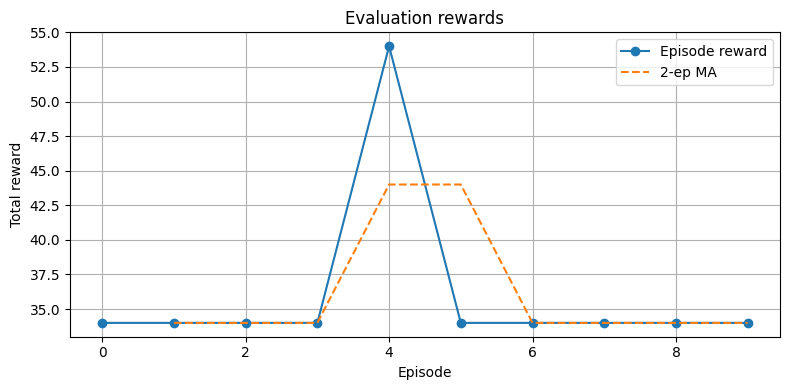


Mean reward: 36.00 ± 6.00
Saved GIF to C:\Users\HP\Programming\ML\formative3_group2_dqn-agent\Benitha\eval_episode.gif


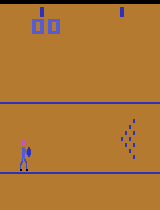

In [7]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import imageio
from IPython.display import Image, display
import gymnasium as gym
from stable_baselines3 import DQN
import ale_py

gym.register_envs(ale_py)

model_filename = Path("benitha_dqn_model.zip")
env_id = "ALE/Bowling-v5"
n_eval_episodes = 10
gif_episode = 0
max_steps_per_episode = 20000

if not model_filename.exists():
    cand = list(Path("..").rglob("benitha_dqn_model.zip"))
    if cand:
        model_filename = cand[0]
    else:
        raise FileNotFoundError(f"Could not find `benitha_dqn_model.zip` in the workspace")

print("Using model:", model_filename.resolve())

env = gym.make(env_id, render_mode="rgb_array")

model = DQN.load(str(model_filename), env=env)

episode_rewards = []
gif_frames = []

for ep in range(n_eval_episodes):
    obs, info = env.reset()
    done = False
    truncated = False
    ep_reward = 0.0
    steps = 0

    while not (done or truncated):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env.step(action)
        
        ep_reward += float(reward)

        if ep == gif_episode:
            gif_frames.append(env.render())

        steps += 1
        if steps >= max_steps_per_episode:
            break

    episode_rewards.append(ep_reward)
    print(f"Episode {ep+1}/{n_eval_episodes}: reward = {ep_reward:.2f} (steps={steps})")

env.close()

plt.figure(figsize=(8,4))
plt.plot(episode_rewards, marker='o', label='Episode reward')
window = max(1, n_eval_episodes // 4)
ma = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')
plt.plot(range(window-1, window-1+len(ma)), ma, linestyle='--', label=f'{window}-ep MA')
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.title('Evaluation rewards')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nMean reward: {np.mean(episode_rewards):.2f} ± {np.std(episode_rewards):.2f}")

if gif_frames:
    gif_path = Path("eval_episode.gif")
    frames_uint8 = []
    for f in gif_frames:
        arr = np.asarray(f)
        if arr.dtype != np.uint8:
            arr = (255.0 * (arr - arr.min())/(arr.max() - arr.min() + 1e-8)).astype(np.uint8)
        frames_uint8.append(arr)
    imageio.mimsave(gif_path, frames_uint8, fps=30)
    print(f"Saved GIF to {gif_path.resolve()}")
    display(Image(filename=str(gif_path)))
else:
    print("No frames captured for GIF.")